In [10]:
import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers, mixed_precision
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, Reshape, GlobalAveragePooling2D, Concatenate, LeakyReLU, BatchNormalization
from tensorflow.keras.utils import plot_model
import time

from IPython import display
from tqdm import tqdm

tf.__version__

'2.17.0'

In [2]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [3]:
BATCH_SIZE = 32
N_CLASS = 10 # number of classes
H, W, CH = (28, 28, 1) # shape of the images

EPOCHS = 50
NOISE_DIM = 100
num_examples_to_generate = 16

In [4]:
(train_images, train_labels), (_, _) = keras.datasets.mnist.load_data()

train_images = train_images.reshape(
    train_images.shape[0], H, W, CH).astype('float32')

# Normalize the images to [-1, 1]
train_images = train_images/255.

In [5]:
BUFFER_SIZE = len(train_images)

In [27]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE, seed=42).batch(BATCH_SIZE)
train_dataset = train_dataset.map(lambda x,y: (x,tf.one_hot(y,depth=N_CLASS)), num_parallel_calls=tf.data.AUTOTUNE)

In [28]:
def random_zoom(image, img_W=W, img_H=H):
    zoom_factor = tf.random.uniform([1], minval=0.85, maxval=1.0)[0]
    result = tf.image.central_crop(image, central_fraction=zoom_factor)
    return tf.image.resize_with_pad(result, img_H, img_W)


def random_zoom_out(image, img_W=W, img_H=H):
    zoom_out_factor_temp = tf.random.uniform(
        [1], minval=1, maxval=img_W//2, dtype=tf.int32)
    zoom_out_factor = zoom_out_factor_temp[0]*2
    result = tf.image.pad_to_bounding_box(
        image, zoom_out_factor//2, zoom_out_factor//2, img_W+zoom_out_factor, img_H+zoom_out_factor)
    return tf.image.resize_with_pad(result, img_W, img_H)

def apply_to_batch(batch):
    random_binary = tf.random.uniform([], minval=0, maxval=2, dtype=tf.int32)
    if (random_binary == 0):
        res = random_zoom(batch)
    else:
        res = random_zoom_out(batch)
    return res

def aug(x, y):
    x = tf.map_fn(fn=lambda img: apply_to_batch(img), elems=x)
    x = tf.image.random_contrast(x, lower=0.9, upper=1.1)
    x = tf.clip_by_value(x, 0.0, 1.0)
    return x, y

train_dataset = train_dataset.map(lambda x, y: aug(x, y), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(lambda x, y: aug(x, y), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

(32, 28, 28, 1) (32, 10)


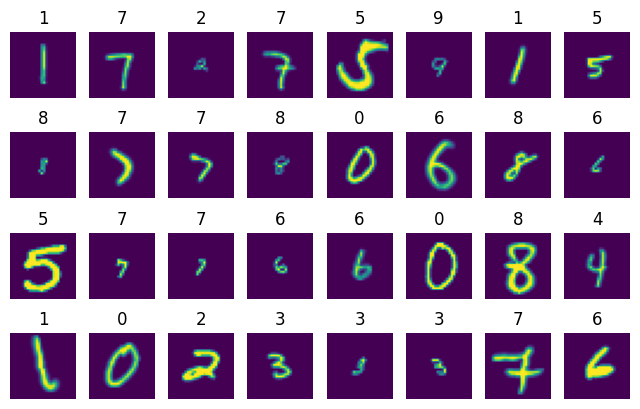

In [31]:
x, y = next(iter(train_dataset))
print(x.shape, y.shape)
fig = plt.figure(figsize=(8, 5))
for i in range(BATCH_SIZE):
    label = (tf.argmax(y[i])).numpy()
    fig.add_subplot(4, 8, i+1)
    plt.imshow(x[i], vmin=0, vmax=1)
    plt.title(label)
    plt.axis('off')
plt.show()

In [287]:
class BlockConv(keras.Layer):
    def __init__(self, filters, kernel, activation, m):
        super(BlockConv, self).__init__()
        self.filters = filters
        self.kernel = kernel
        self.activation = activation
        self.m = m
        self.blockSeq = keras.Sequential([
            Conv2DTranspose(self.filters*self.m, self.kernel, strides=(2, 2), padding="same", use_bias=False, activation=self.activation),
            Conv2DTranspose(self.filters*(self.m+1), self.kernel, strides=(1, 1), padding="same", use_bias=False, activation=self.activation),
            Conv2DTranspose(self.filters*(self.m+2), self.kernel, strides=(1, 1), use_bias=False, activation=self.activation),
            BatchNormalization(),
        ])


    def call(self, input, training=True):
        return self.blockSeq(input)

In [288]:
class Generator(keras.Model):
    def __init__(self, filters=32, dropout_dim=0.3, size_min=2, activationF = "relu"):
        super(Generator, self).__init__()
        self.dropout_dim = dropout_dim
        self.filters = filters
        self.size_min = size_min
        self.activation = activationF
        self.blockConv1 = BlockConv(self.filters, (3, 3), self.activation, 4)
        self.blockConv2 = BlockConv(self.filters, (3, 3), self.activation, 3)
        self.blockConv3 = BlockConv(self.filters, (3, 3), self.activation, 2)
        self.BatchNorm1 = BatchNormalization()
        self.BatchNorm2 = BatchNormalization()
        self.BatchNorm3 = BatchNormalization()
        self.BatchNorm4 = BatchNormalization()
        self.dense = Dense(self.size_min*self.size_min*self.filters, use_bias=False, activation=self.activation)
        self.inputs_noise = keras.Sequential([
            Dense(self.filters, activation=self.activation),
            Dense(self.filters//2, activation=self.activation),
            BatchNormalization(),
            Dropout(self.dropout_dim),
        ])
        self.inputs_labels = keras.Sequential([
            Dense(self.filters, activation=self.activation),
            Dense(self.filters//2, activation=self.activation),
            BatchNormalization(),
            Dropout(self.dropout_dim),
        ])
        self.outputsLayer = keras.Sequential([
            Conv2D(self.filters//2, (3,3), use_bias=False, activation=self.activation),
            Conv2D(CH, 1, padding="same", activation="sigmoid", dtype='float32', use_bias=False, name='output'),
        ])

    def call(self, inputs, size_min=2, training=True, **kwargs):
        noise= inputs[0]
        labels = inputs[1]
        x = Concatenate(axis=1)(
            [self.inputs_noise(noise), self.inputs_labels(labels)])

        x = self.dense(x)
        x = Reshape((self.size_min, self.size_min, self.filters))(x)
        x = self.BatchNorm1(x)

        x = self.blockConv1(x)
        x = self.BatchNorm2(x)
        
        x = self.blockConv2(x)
        x = self.BatchNorm3(x)
        
        x = self.blockConv3(x)
        x = self.BatchNorm4(x)
        
        outputs = self.outputsLayer(x)

        return outputs
generator = Generator(filters=64)

(1, 28, 28, 1)


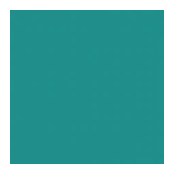

In [289]:
noise = tf.random.normal([1, NOISE_DIM])
labels = np.zeros((1, N_CLASS))
labels[0][0] = 1
labels = tf.constant(labels)
generated_image = generator.predict([noise, labels], verbose=0)
print(generated_image.shape)
plt.figure(figsize=(2,2))
plt.imshow(generated_image[0, :, :, 0], vmin=0, vmax = 1)
plt.axis(False)
plt.show()


In [290]:
generator.summary()

Model: "generator_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block_conv_9 (BlockConv)        │ ?                      │     1,992,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_conv_10 (BlockConv)       │ ?                      │     1,844,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_conv_11 (BlockConv)       │ ?                      │     1,033,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (1, 2, 2, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (1, 6, 6, 384)         │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (1, 14, 14, 320)       │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (1, 30, 30, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (1, 256)               │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_45 (Sequential)      │ (1, 32)                │         8,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_46 (Sequential)      │ (1, 32)                │         2,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_47 (Sequential)      │ (1, 28, 28, 1)         │        73,760 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,975,712 (18.98 MB)

 Trainable params: 4,971,616 (18.97 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [291]:
class DiscrBlock(keras.Layer):
    def __init__(self, filters, activationF, m, kernel=(3,3)):
        super(DiscrBlock, self).__init__()
        self.filters = filters
        self.kernel = kernel
        self.activation = activationF
        self.m = m
        self.convolutionBlocks = keras.Sequential({
            Conv2D(self.filters*self.m, kernel_size= self.kernel, activation=self.activation, padding='same'),
            Conv2D(self.filters*(self.m+1), kernel_size= self.kernel, activation=self.activation, padding='same'),
            Conv2D(self.filters*(self.m+2), kernel_size= self.kernel, activation=self.activation, padding='same'),
            MaxPooling2D((2, 2)),
        })
    def call(self, inputs):
        return self.convolutionBlocks(inputs)

class Discriminator(keras.Model):
    def __init__(self, filters=32, activationF="relu", *args, **kwargs):
        super(Discriminator, self).__init__(*args, **kwargs)
        self.filters = filters
        self.activation = activationF
        self.discr = keras.Sequential([
            DiscrBlock(filters=self.filters, activationF=self.activation, m=1),
            DiscrBlock(filters=self.filters, activationF=self.activation, m=2),
            DiscrBlock(filters=self.filters, activationF=self.activation, m=3),
            Flatten(),
            Dropout(0.3),
            Dense(self.filters, activation=self.activation),
            Dense(N_CLASS, activation='softmax')
        ])
        
    def call(self, inputs, training=False, **kwargs):
        return self.discr(inputs)

discriminator = Discriminator()

In [292]:
decision = discriminator.predict(generated_image, verbose=0)
print(decision)
discriminator.summary()

[[0.10016 0.10004 0.1     0.09985 0.0998  0.1     0.1     0.10004 0.0999
  0.10016]]


Model: "discriminator_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_51 (Sequential)      │ (1, 10)                │       665,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 665,354 (2.54 MB)

 Trainable params: 665,354 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

In [293]:
class AdversarialBlock(keras.Layer):
    def __init__(self, filters, activationF, m, kernel=(3,3)):
        super(AdversarialBlock, self).__init__()
        self.filters = filters
        self.kernel = kernel
        self.activation = activationF
        self.m = m
        self.convBlocks = keras.Sequential({
            Conv2D(self.filters*self.m, kernel_size= self.kernel, activation=self.activation, padding='same'),
            Conv2D(self.filters*(self.m+1), kernel_size= self.kernel, activation=self.activation, padding='same'),
            Conv2D(self.filters*(self.m+2), kernel_size= self.kernel, activation=self.activation, padding='same'),
            MaxPooling2D((2, 2)),
        })
    def call(self, inputs):
        return self.convBlocks(inputs)

class Adversarial(keras.Model):
    def __init__(self, filters=32, activationF="relu", *args, **kwargs):
        super(Adversarial, self).__init__(*args, **kwargs)
        self.filters = filters
        self.activation = activationF
        self.adv = keras.Sequential([
            AdversarialBlock(filters=self.filters, activationF=self.activation, m=1),
            AdversarialBlock(filters=self.filters, activationF=self.activation, m=2),
            AdversarialBlock(filters=self.filters, activationF=self.activation, m=3),
            Flatten(),
            Dropout(0.3),
            Dense(self.filters//2, activation=self.activation),
            Dense(1, activation='sigmoid')
        ])
        
    def call(self, inputs, training=False, **kwargs):
        return self.adv(inputs)

adversarial = Adversarial(filters=128)



In [294]:
generated_image.shape

(1, 28, 28, 1)

In [295]:
res_adv = adversarial.predict(generated_image, verbose=0)
print(res_adv)
adversarial.summary()

[[0.5]]


Model: "adversarial_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_55 (Sequential)      │ (1, 1)                 │    11,582,337 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,582,337 (44.18 MB)

 Trainable params: 11,582,337 (44.18 MB)

 Non-trainable params: 0 (0.00 B)

In [296]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

# Definizione della loss adversarial


def adversarial_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    real_loss = tf.cast(real_loss, tf.float16)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    fake_loss = tf.cast(fake_loss, tf.float16)
    total_loss = real_loss + fake_loss
    return total_loss

# Definizione della loss di discriminator


def discriminator_loss(labels, labels_predictions):
    loss = tf.keras.losses.categorical_crossentropy(labels, labels_predictions)
    return tf.reduce_mean(loss)

# Definizione della loss totale per il generatore


def generator_loss(adv_loss, class_loss, lambda_val=.8):
    total_loss = tf.exp(-1*(adv_loss)) + lambda_val * class_loss
    return total_loss

In [297]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
adversari_optimizer = tf.keras.optimizers.Adam(1e-4)

In [298]:
# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
noise = tf.random.normal([num_examples_to_generate, NOISE_DIM])
labels = np.zeros((num_examples_to_generate, N_CLASS))
for i, label in enumerate(labels):
    label[i % N_CLASS] = 1
labels = tf.constant(labels)
seed = (noise, labels)

In [299]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(image_batch):
    images, labels = image_batch
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape, tf.GradientTape() as adv_tape:
        generated_images = generator([noise, labels], training=True)

        adv_real_output = adversarial(images, training=True)
        adv_fake_output = adversarial(generated_images, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        adv_loss = adversarial_loss(adv_real_output, adv_fake_output)
        disc_loss_real = discriminator_loss(labels, real_output)
        disc_loss_fake = discriminator_loss(labels, fake_output)
        
        
        gen_loss = generator_loss(adv_loss, disc_loss_fake)
        

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss_real, discriminator.trainable_variables)
    gradients_of_adversarial = adv_tape.gradient(adv_loss, adversarial.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    adversari_optimizer.apply_gradients(zip(gradients_of_adversarial, adversarial.trainable_variables))
    return (gen_loss, disc_loss_real, adv_loss)

In [300]:
def generate_and_save_images(model, gen_loss, disc_loss, adv_loss):
    noise = tf.random.normal([num_examples_to_generate, NOISE_DIM])
    labels = np.zeros((num_examples_to_generate, N_CLASS))
    for i, label in enumerate(labels):
        label[i % N_CLASS] = 1
    labels = tf.constant(labels)
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model.predict([noise, labels], verbose=0)

    fig = plt.figure(figsize=(4, 5))
    for i in range(num_examples_to_generate):
        label = (tf.argmax(labels[i])).numpy()
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], vmin=0, vmax=1)
        plt.axis('off')
        plt.title(label)

    plt.show()

    plt.figure()
    plt.plot(gen_loss, label='generator')
    plt.plot(disc_loss, label='discriminator')
    plt.plot(adv_loss, label='adversarial')
    plt.legend()
    plt.show()

In [301]:
gen_loss = []
disc_loss = []
adv_loss = []


def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        gen_loss_batch = np.zeros(len(dataset))
        disc_loss_batch = np.zeros(len(dataset))
        adv_loss_batch = np.zeros(len(dataset))
        i = 0
        for image_batch in tqdm(dataset, desc='Train'):
            g, d, a = train_step(image_batch)
            gen_loss_batch[i] = np.average(g)
            disc_loss_batch[i] = np.average(d)
            adv_loss_batch[i] = np.average(a)
            i += 1

        gen_loss.append(np.average(gen_loss_batch))
        disc_loss.append(np.average(disc_loss_batch))
        adv_loss.append(np.average(adv_loss_batch))

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator, gen_loss, disc_loss, adv_loss)

        print('Time for epoch {}/{} is {} sec.\nGen. loss: {};\nDisc. loss: {};\nAdv. loss: {}'.format(
            epoch + 1, EPOCHS, round(time.time()-start, 4), round(gen_loss[-1], 4), round(disc_loss[-1], 4), round(adv_loss[-1], 4)))

    # Generate after the final sada
    display.clear_output(wait=True)
    generate_and_save_images(generator,gen_loss,disc_loss,adv_loss)

In [177]:
train(train_dataset, EPOCHS)

Train:   0%|          | 0/1875 [00:00<?, ?it/s]

In [285]:
generator.save('model/generator_numbers_selected.keras')

(32, 28, 28, 1) (32, 10)


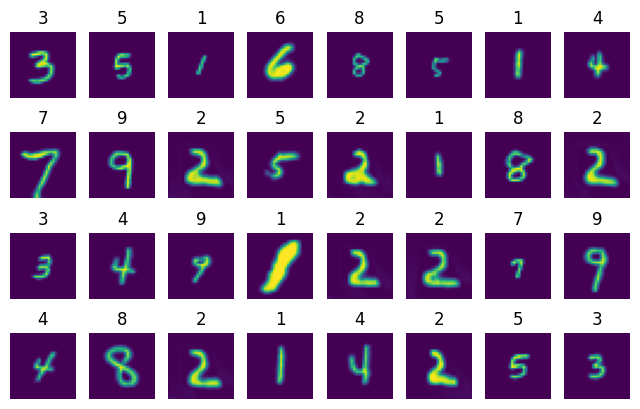

In [179]:
x, y = next(iter(train_dataset))
print(x.shape, y.shape)
fig = plt.figure(figsize=(8, 5))
noise = tf.random.normal([x.shape[0], NOISE_DIM])
x_pred = generator.predict([noise,y], verbose=False)

for i in range(32):
    label = (tf.argmax(y[i])).numpy()
    
    fig.add_subplot(4, 8, i+1)
    plt.imshow(x_pred[i], vmin=0, vmax=1)
    plt.title(label)
    plt.axis('off')
plt.show()

tf.Tensor([[1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


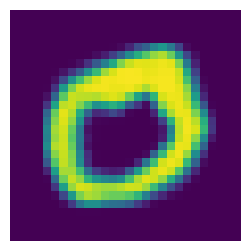

In [284]:
# Richiesta mista con due numeri
N = 5
N_2 = 0
N_hot = tf.one_hot(N, N_CLASS)
N_hot = tf.expand_dims(N_hot, axis=0)
N_hot_2 = tf.one_hot(N_2, N_CLASS)
N_hot_2 = tf.expand_dims(N_hot_2, axis=0)
N_hot = tf.add(N_hot, N_hot_2)
# N_hot = tf.zeros_like(N_hot)
print(N_hot)
noise = tf.random.normal([1, NOISE_DIM])
img = generator.predict((noise, N_hot))
plt.figure(figsize=(3,3))
plt.imshow(img[0], vmin=0, vmax=1)
plt.axis(False)
plt.show()